In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
sns.set_context('talk')

In [53]:
df = pd.read_excel(r'/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Data/RE_ Mono vs Bivalent cell binding data - high affinity Ab/ELN339140_Tabular.xlsx')
df = df.dropna(subset=['CELL_ID']).reset_index(drop=True)
#df = df.dropna(subset=['ANTIBODY_ID']).reset_index(drop=True)
df

,EXPERIMENT_ID,EXPERIMENT_TYPE,PLATE_ID,ROW,COLUMN,CELL_ID,ANTIBODY_ID,ANTIBODY_FORMAT,ANTIBODY_CONCENTRATION_MOLAR,RESPONSE
0,ELN339140,CELL_BINDING,1,A,1,MSX_B,28015,BIVALENT,0.000001,7257087.0
1,ELN339140,CELL_BINDING,1,A,2,MSX_B,28015,MONOVALENT,0.000001,7280424.0
2,ELN339140,CELL_BINDING,1,A,3,MSX_B,28008,BIVALENT,0.000001,6219767.0
3,ELN339140,CELL_BINDING,1,A,4,MSX_B,28008,MONOVALENT,0.000001,1927932.0
4,ELN339140,CELL_BINDING,1,A,5,MSX_B,22366,BIVALENT,0.000001,1754864.0
...,...,...,...,...,...,...,...,...,...,...
635,ELN339140,CELL_BINDING,2,P,18,500G_F,22366,MONOVALENT,0.000000,11969.0
636,ELN339140,CELL_BINDING,2,P,19,500G_F,17598,BIVALENT,0.000000,11061.0
637,ELN339140,CELL_BINDING,2,P,20,500G_F,17598,MONOVALENT,0.000000,10196.0
638,ELN339140,CELL_BINDING,2,P,21,500G_F,RSV,BIVALENT,0.000000,12250.0


In [54]:
cell_ids = list(set(df['CELL_ID'].values))
antibody_ids1 = list(set(df['ANTIBODY_ID'].values))
antibody_ids = [x for x in antibody_ids1 if str(x) != 'nan']
antibody_ids.remove('RSV')

def data_extractor(df, cell_id, antibody_id):

    df1 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@antibody_id')
    mono_df = df1.query('ANTIBODY_FORMAT=="MONOVALENT"')
    biv_df = df1.query('ANTIBODY_FORMAT=="BIVALENT"')

    concs = list(np.flip(mono_df['ANTIBODY_CONCENTRATION_MOLAR'].values))
    response_mono = list(np.flip(mono_df['RESPONSE'].values))
    response_biv = list(np.flip(biv_df['RESPONSE'].values))
    return response_mono, response_biv, concs

[28008, 'RSV', 28015, 22366, 17598]


500G_B
[ 9545.5 10493.   9763.   9940.   9612.   9599.5  9486.   9716.   9199.
  9577.   7861.5  7330.   8669.   9428.   7894. ]
500G_L
[7213.  7607.5 8374.  7566.5 7303.  7437.  7173.  7542.  7241.  6512.
 6655.  6903.  7656.  8591.  6630. ]
MSX_B
[  13498.5   35046.    28718.    18647.5   15801.  1024977.    60160.5
   34250.     8531.     7474.5    6969.     8479.     7273.     7608.
    6981. ]
500G_F
[14841.5 14470.  14746.5 14040.  14094.  13929.  12799.  13898.  12103.
 12535.  11002.  10036.  12857.5 13418.  11930. ]


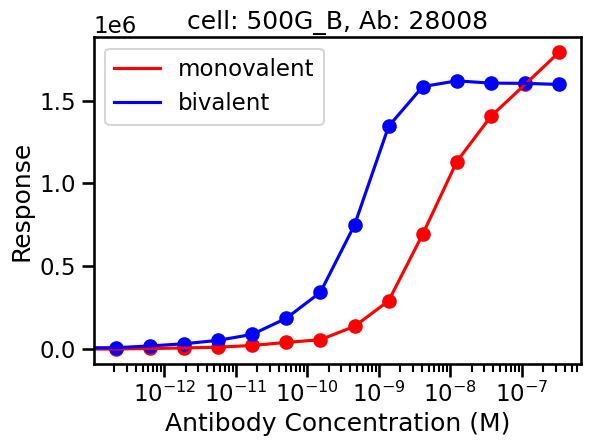

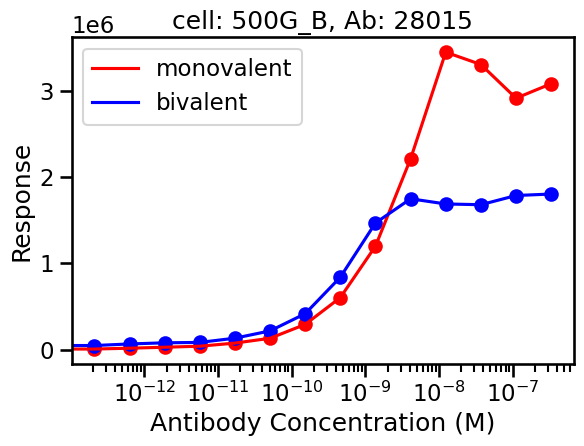

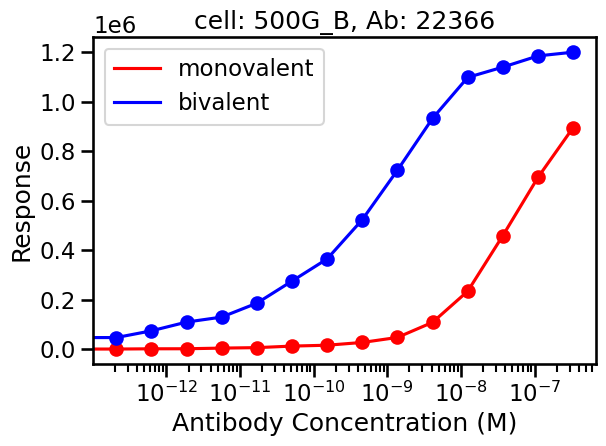

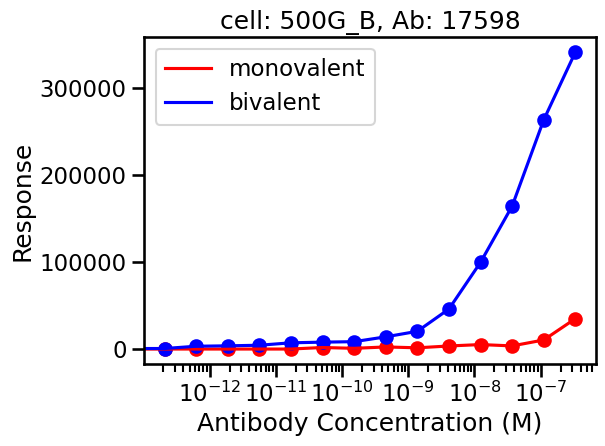

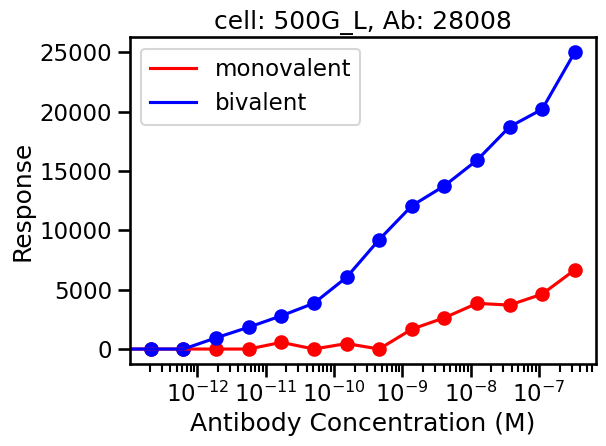

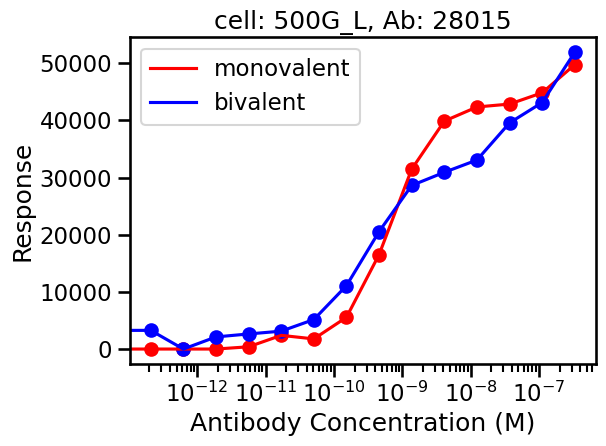

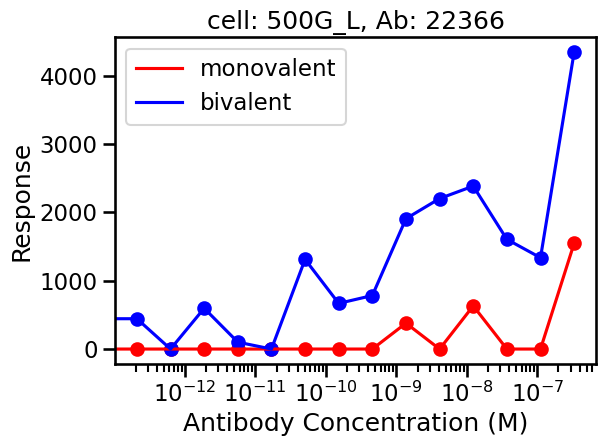

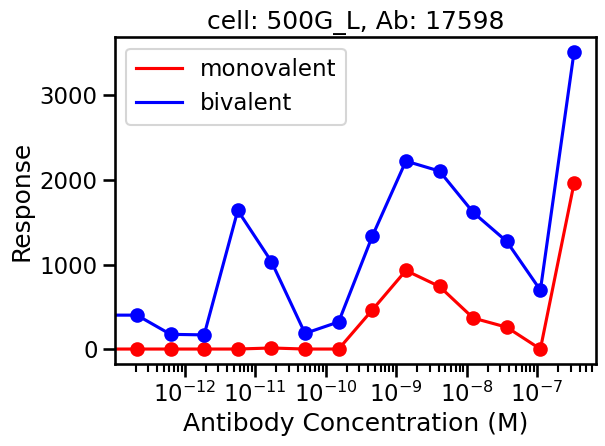

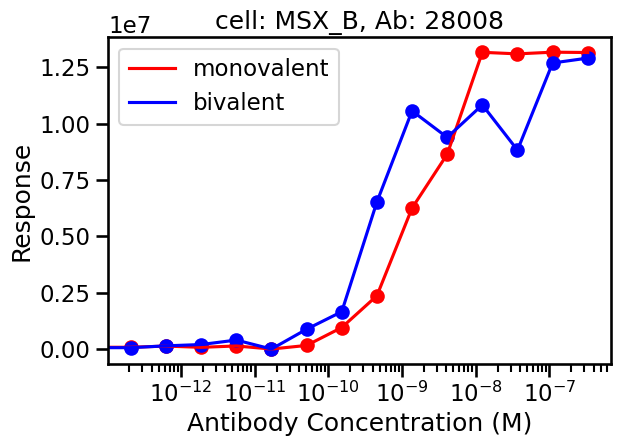

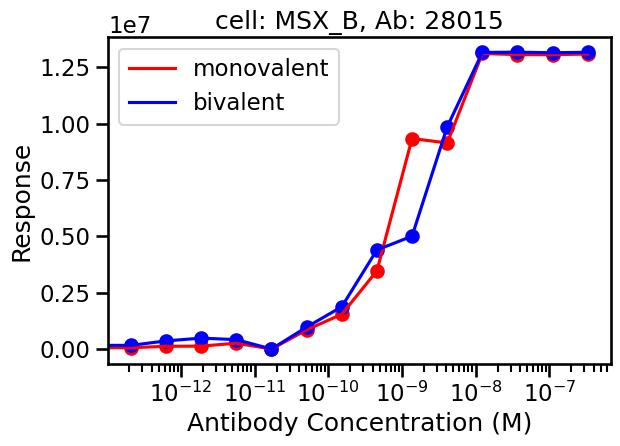

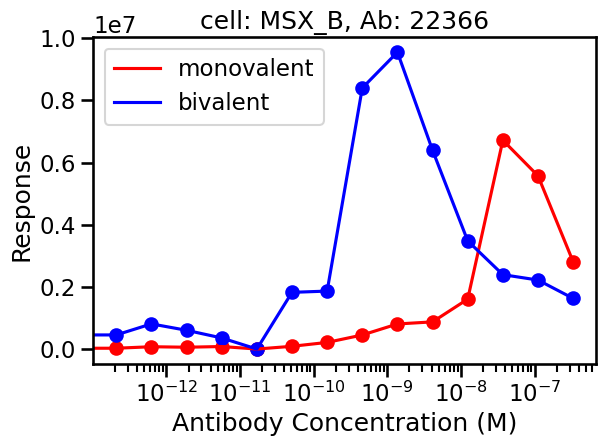

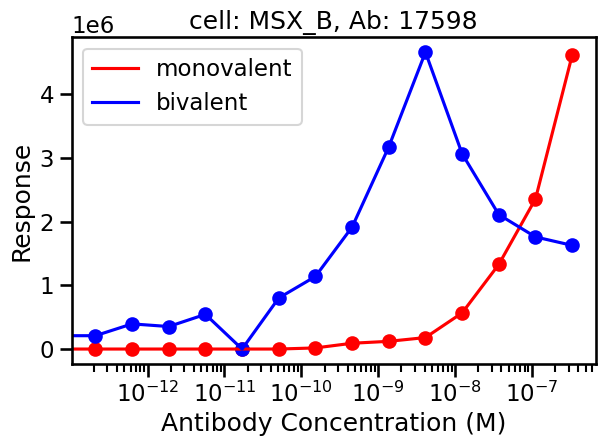

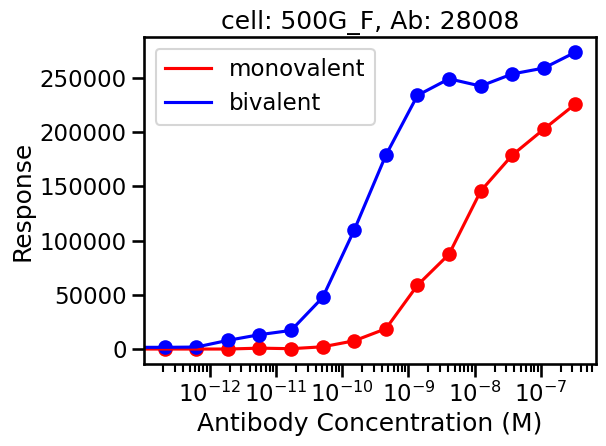

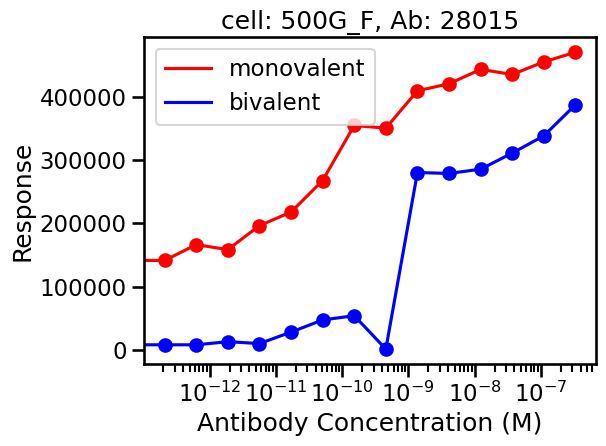

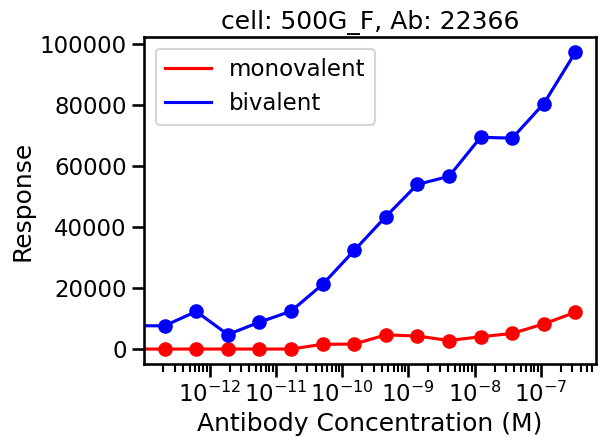

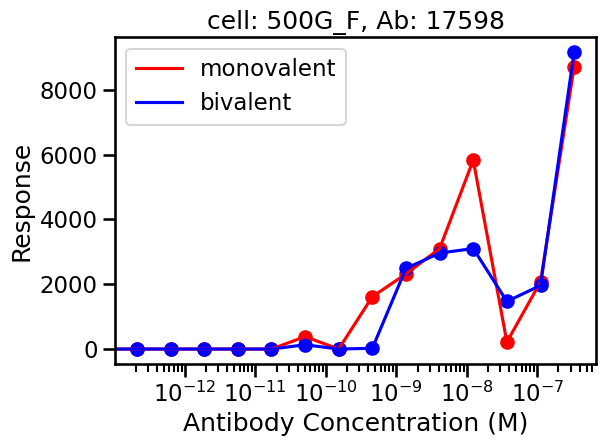

In [55]:
monos = []
bivs = []
concs = []
for cell_id in cell_ids:
    df2 = df.query('CELL_ID==@cell_id')
    df2 = df2.loc[df2['ANTIBODY_ID'].isnull()]
    subtract = df2['RESPONSE'].values
    subtract = np.array(subtract[:-1])
    print(cell_id)
    print(subtract)
    for antibody_id in antibody_ids:
        mono, biv, conc = data_extractor(df, cell_id, antibody_id)
        #remove last data point due to peak effect
        mono = np.array(mono[:-1])
        biv = np.array(biv[:-1])
        conc = np.array(conc[:-1])
        mono = mono - subtract
        biv = biv-subtract
        for i in range(len(mono)):
            if mono[i]<0:
                mono[i]=0
            if biv[i]<0:
                biv[i]=0
        monos.append(mono)
        bivs.append(biv)
        concs.append(conc)
        #rtot = receptor_quant[cell_id]
        fig = plt.figure()
        plt.plot(conc, mono, label = 'monovalent', c='red')
        plt.plot(conc, biv, label = 'bivalent', c='blue')
        plt.scatter(conc, mono, c='red')
        plt.scatter(conc, biv, c='blue')
        plt.legend(loc='best')
        plt.ylabel('Response')
        plt.xscale('log')
        plt.xlabel('Antibody Concentration (M)')
        name = str(cell_id) + str(antibody_id)
        plt.title('cell: ' + str(cell_id) + ', ' + 'Ab: ' + str(antibody_id))
        filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Plots2/%s.png' % name
        plt.tight_layout()
        #fig.savefig(filename)

In [9]:
receptor_quant = {'500G_F': 11394, 'MSX_B':1670228, '500G_B':107477, '500G_L':1279}
kons = [10**(5.6), 10**(5.02), 10**(5.07), 10**(6.06)]
KDs = [10**(-8.3), 10**(-10.22), 10**(-8.5), 10**(-8.93)]
k2s = [10**(-5), 10**(-5.57), 10**(-4.29), 10**(-8.54)]
koffs = [KDs[i]*kons[i] for i in range(len(KDs))]
expressions = [1279, 11394, 107477, 1670228]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

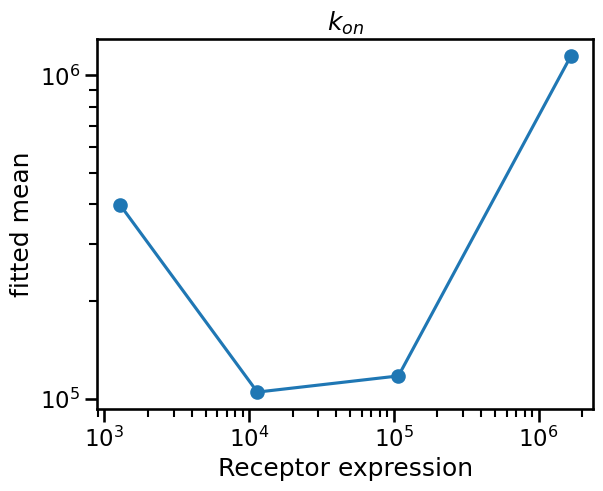

In [20]:
plt.scatter(expressions, kons)
plt.plot(expressions,kons)
plt.xlabel('Receptor expression')
plt.ylabel('fitted mean')
plt.title(r'$k_{on}$')
plt.xscale('log')
plt.yscale('log')

In [36]:
receptor_quant = {'500G_F': 11394, 'MSX_B':1670228, '500G_B':107477, '500G_L':1279,
                  '250G_A':71651, '250G_C': 54641, 'MSX_A': 1338209, 'MSX_C':1420828,
                  'MSX_D': 991, 'MSX_E': 1109, 'MSX_F': 11662, '500G_A': 83613,
                  '500G_C': 84811, '500G_D': 8365, '500G_E': 5521, '500G_H': 4487,
                  '500G_I': 9008, '500G_J': 5343, '500G_K': 1038}

bad_fits = ['MSX_E', 'MSX_D', 'MSX_A', '500G_L', '500G_K']

for key in bad_fits:
    del receptor_quant[key]

In [24]:
import pandas as pd

In [37]:
keys_list= list(receptor_quant.keys())
param_dict = {}
for key in keys_list:
    filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/results_high_aff/results_%s28015.csv' % key
    df = pd.read_csv(filename)
    param_dict[key] = param_means = df['mean'].values
print(param_dict)

{'500G_F': array([ 6.34261962, -9.08230065, -4.56291094,  1.53699239]), 'MSX_B': array([  6.07077532, -10.78283798, -10.46404084,   0.89607215]), '500G_B': array([ 5.7601811 , -8.61042134, -4.66366877,  1.47539028]), '250G_A': array([ 5.95643427, -8.72050028, -4.34344581,  1.74334819]), '250G_C': array([ 6.15789851, -8.75694707, -4.11418601,  1.69983596]), 'MSX_C': array([  5.42114543, -10.85839693, -10.63433207,   0.96514584]), 'MSX_F': array([ 6.01563274, -8.81007585, -4.01738511,  1.64327514]), '500G_A': array([ 5.44881498, -8.53212834, -3.49441392,  1.72273867]), '500G_C': array([ 5.54117901, -8.57593748, -4.75506877,  1.53875354]), '500G_D': array([ 6.38070552, -9.06248776, -3.75762133,  1.59743917]), '500G_E': array([ 6.34622415, -9.09700821, -4.08846887,  1.63447328]), '500G_H': array([ 6.3282723 , -9.0731174 , -3.90240444,  1.67678792]), '500G_I': array([ 6.30309856, -9.0956689 , -4.2066567 ,  1.47437309]), '500G_J': array([ 6.38393662, -9.11455375, -3.8747182 ,  1.77901612])}


In [38]:
rtots = []
kons = []
Kds = []
k2s = []
koffs = []
for key in keys_list:
    rtots.append(receptor_quant[key])
    params = param_dict[key]
    kons.append(params[0])
    Kds.append(params[1])
    k2s.append(params[2])
    koffs.append(params[1] + params[0])

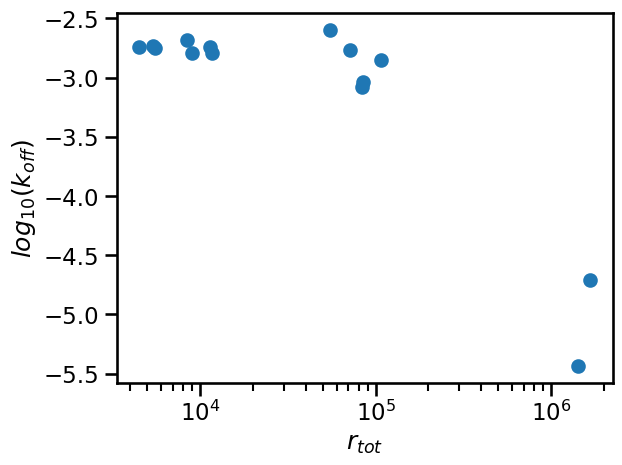

In [48]:
plt.scatter(rtots, koffs)
plt.ylabel(r'$log_{10}(k_{off})$')
plt.xlabel(r'$r_{tot}$')
#plt.ylim((5, 6.5))
plt.xscale('log')